In [1]:
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statannotations.Annotator import Annotator

A function to select the the top 100 moelcules in a dataframe column and determine how many unique R1, R2, etc are present. 

In [2]:
def process_column(df,col):
    top_df = pd.DataFrame(df.sort_values(col,ascending=False).head(100))
    top_mean = top_df[col].mean()                          
    tmp_df = pd.DataFrame(top_df.Name.str.split("_").values.tolist())
    return [len(tmp_df[x].unique()) for x in tmp_df.columns],top_mean

A fucnction to ead and integrate data from the csv files in the **results** directory and the parquet files in the **parquet** directory. 

In [3]:
def process_files(parquet_directory, results_directory):
    df_list = []
    for filename in tqdm(glob(parquet_directory + "*.parquet")):
        base_name = os.path.split(filename)[-1]
        base_name = base_name.replace(".parquet","")
        ts_df = pd.read_csv(f"{results_directory}{base_name}_TS_results.csv")
        ts_df.rename(columns={"Mean" : "TS_Mean"},inplace=True)
        ts_df['Method'] = 'TS'
        rws_df = pd.read_csv(f"{results_directory}{base_name}_RWS_results.csv")
        rws_df.rename(columns={"Mean" : "RWS_Mean"},inplace=True)
        rws_df['Method'] = 'RWS'
        df = pd.read_parquet(filename)
        res_list = []
        for col in tqdm(df.columns):
            if col.startswith("query"):
                res, top_mean = process_column(df,col)
                res_list.append([col,res,sum(res)])
        res_df = pd.DataFrame(res_list,columns=["Query","bbs","bbsum"])
        combo_df = res_df.merge(ts_df[["Query","TS_Mean"]],on="Query")
        combo_df = combo_df.merge(rws_df[["Query","RWS_Mean"]],on="Query")
        combo_df["lib"] = base_name
        df_list.append(combo_df)
    all_df = pd.concat(df_list)
    return all_df

Collect the data from the 2-component and 3-component libraries. 

In [4]:
base_results_directory = "/Users/pwalters/software/TS_2025/results/"
base_parquet_directory = "/Users/pwalters/software/TS_2025/parquet/"
results_dict = {}
for component_directory in ["2_component","3_component"]:
    print(component_directory)
    parquet_directory = f"{base_parquet_directory}{component_directory}/"
    results_directory = f"{base_results_directory}{component_directory}/"
    results_dict[component_directory] = process_files(parquet_directory, results_directory)

2_component


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

3_component


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Get results from the dictiory we created in the cell above

In [6]:
df_2_cmp = results_dict["2_component"]
df_3_cmp = results_dict["3_component"]

Plot the correlation between TS and RWS recoveries for 2-component and 3-component libraries

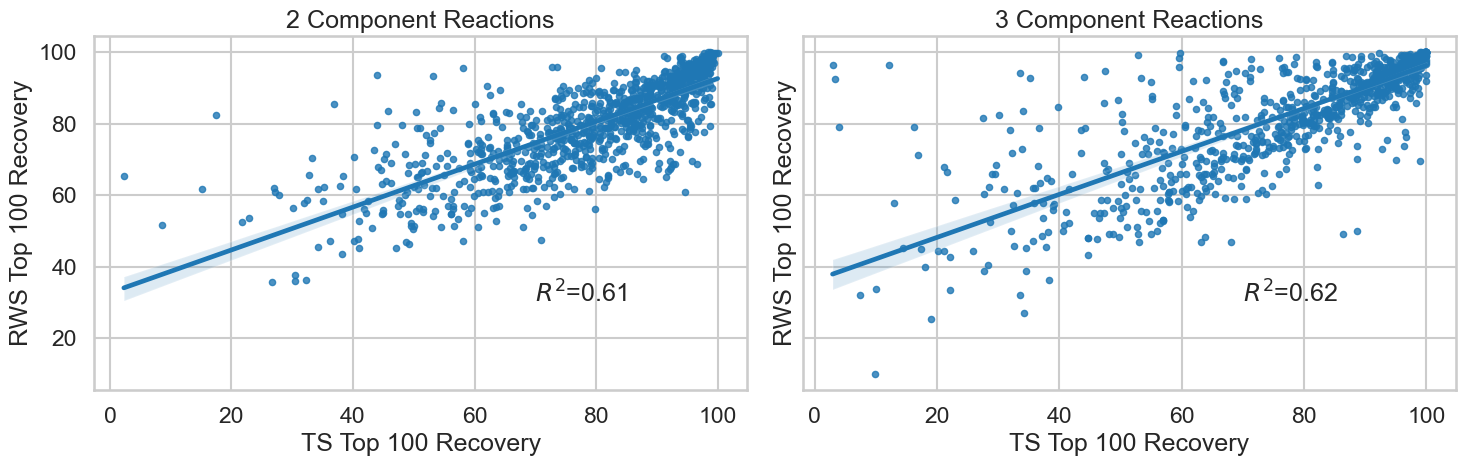

In [8]:
sns.set_style('whitegrid')
sns.set_context('talk')
figure, axes = plt.subplots(1,2,figsize=(15,5),sharey=True)
axes = axes.flatten()
ax1 = sns.regplot(x="TS_Mean",y="RWS_Mean",data=df_2_cmp,scatter_kws={"s" : 20},ax=axes[0])
ax1.set_xlabel("TS Top 100 Recovery")
ax1.set_ylabel("RWS Top 100 Recovery")
ax1.set_title("2 Component Reactions")
r2_1 = r2_score(df_2_cmp.TS_Mean,df_2_cmp.RWS_Mean)
ax1.text(70,30,f"$R^2$={r2_1:.2f}")
ax2 = sns.regplot(x="TS_Mean",y="RWS_Mean",data=df_3_cmp,scatter_kws={"s" : 20},ax=axes[1])
ax2.set_xlabel("TS Top 100 Recovery")
ax2.set_ylabel("RWS Top 100 Recovery")
ax2.set_title("3 Component Reactions")
r2_2 = r2_score(df_3_cmp.TS_Mean,df_3_cmp.RWS_Mean)
ax2.text(70,30,f"$R^2$={r2_2:.2f}")
plt.tight_layout()

Combine the 2-component and 3-component data into a single dataframe

In [23]:
df_2_cmp["Reaction Components"] = 2
df_3_cmp["Reaction Components"] = 3
df_cmp_combo = pd.concat([df_2_cmp, df_3_cmp])
tmp_df = df_cmp_combo[['Query','TS_Mean','RWS_Mean','Reaction Components']]

Plot frequency histograms showing top 100 recoveries. 

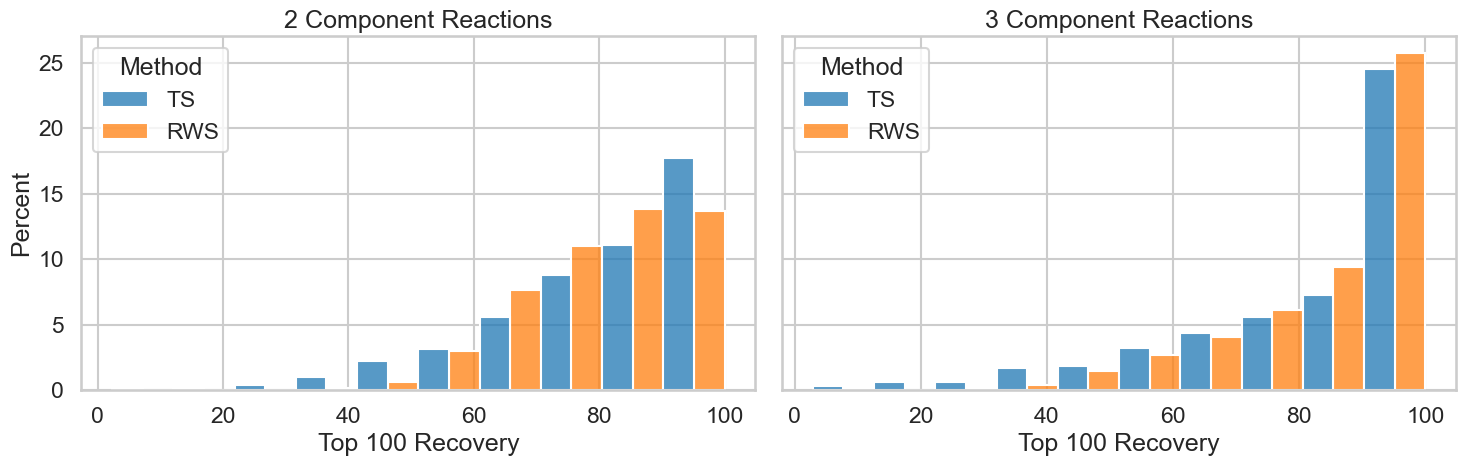

In [37]:
figure, axes = plt.subplots(1,2,figsize=(15,5),sharey=True)
hue_order = ['RWS','TS']
melt_df = tmp_df.melt(id_vars=['Query','Reaction Components'])
melt_df.columns = ["Query","Reaction_Components","Method","Top 100 Recovery"]
melt_df['Method'] = melt_df['Method'].str.split("_").str[0]
ax0 = sns.histplot(x="Top 100 Recovery",hue="Method",data=melt_df.query("Reaction_Components == 2"),multiple="dodge",bins=10,ax=axes[0],stat='percent')
sns.move_legend(ax0,"upper left")
#ax0.legend(title="Method",labels=['TS','RWS'],loc='upper left')
ax0.set_title("2 Component Reactions")
ax1 = sns.histplot(x="Top 100 Recovery",hue="Method",data=melt_df.query("Reaction_Components == 3"),multiple="dodge",bins=10,ax=axes[1],stat='percent')
#ax1.legend(title='Method', labels=['TS', 'RWS'], loc='upper left')
ax1.set_title("3 Component Reactions")
plt.tight_layout()

Plot the top 100 recovery as a function of the number of building blocks in the top 100.  This enables us to asses the impact of diversity on top 100 recovery. 

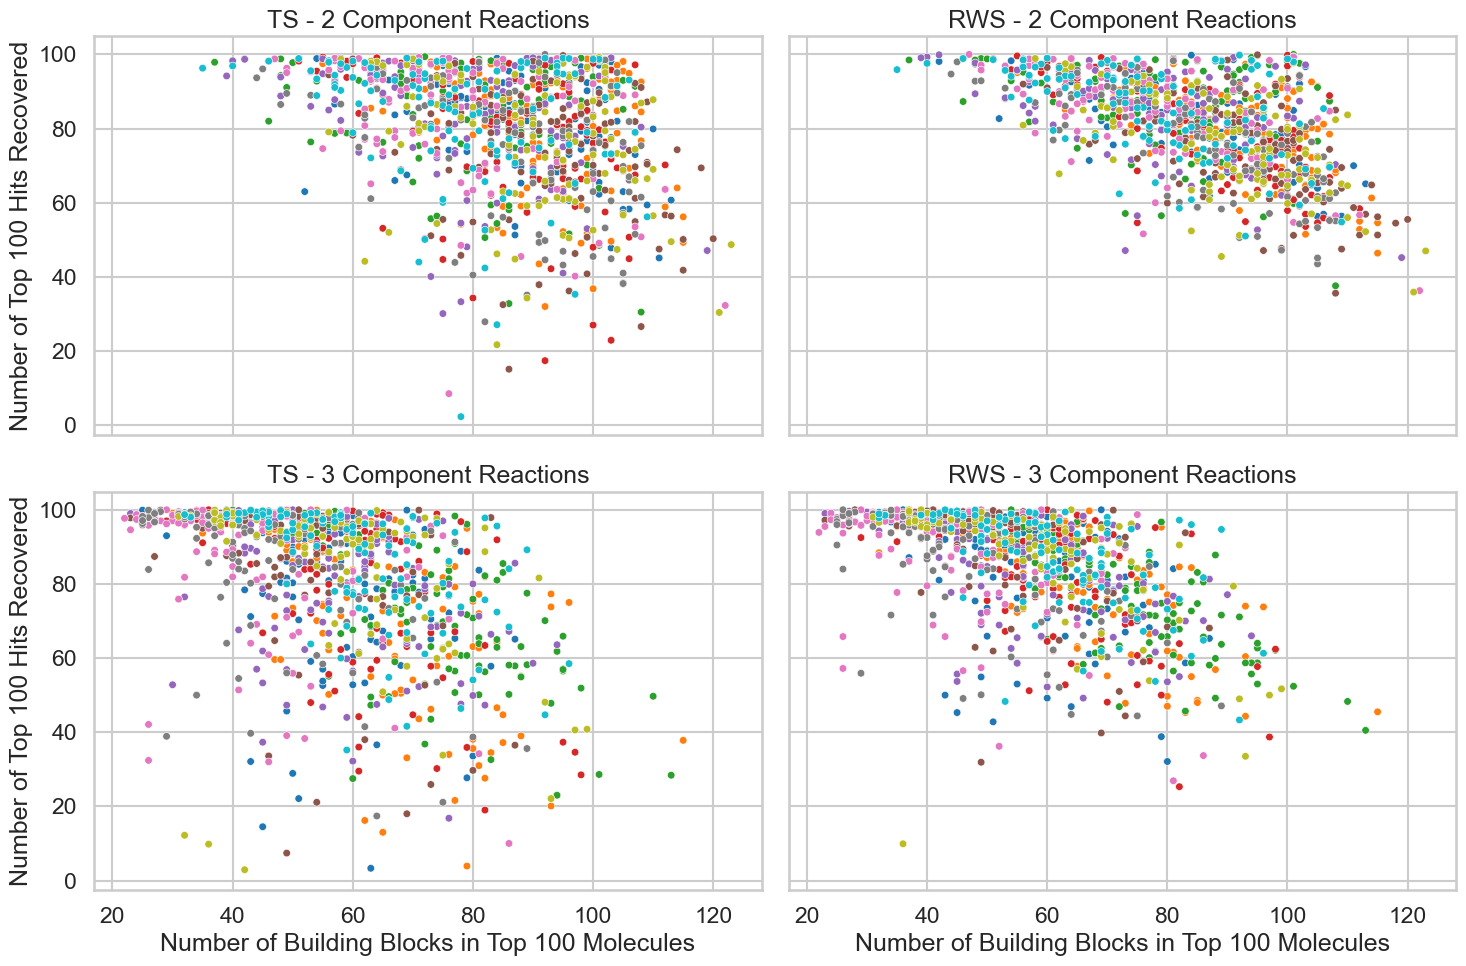

In [212]:
sns.set_style('whitegrid')
sns.set_context('talk')
figure, axes = plt.subplots(2,2,figsize=(15,10),sharey=True,sharex=True)
axes = axes.flatten()
ax1 = sns.scatterplot(x="bbsum",y="TS_Mean",hue="lib",data=df_2_cmp,legend=None,ax=axes[0],s=30)
ax1.set_title("TS - 2 Component Reactions")
ax1.set_xlabel("Number of Building Blocks in Top 100 Molecules")
ax1.set_ylabel("Number of Top 100 Hits Recovered")
ax2 = sns.scatterplot(x="bbsum",y="RWS_Mean",hue="lib",data=df_2_cmp,legend=None,ax=axes[1],s=30)
ax2.set_title("RWS - 2 Component Reactions")
ax2.set_xlabel("Number of Building Blocks in Top 100 Molecules")

ax3 = sns.scatterplot(x="bbsum",y="TS_Mean",hue="lib",data=df_3_cmp,legend=None,ax=axes[2],s=30)
ax3.set_title("TS - 3 Component Reactions")
ax3.set_xlabel("Number of Building Blocks in Top 100 Molecules")
ax3.set_ylabel("Number of Top 100 Hits Recovered")
ax4 = sns.scatterplot(x="bbsum",y="RWS_Mean",hue="lib",data=df_3_cmp,legend=None,ax=axes[3],s=30)
ax4.set_title("RWS - 3 Component Reactions")
ax4.set_xlabel("Number of Building Blocks in Top 100 Molecules")

plt.tight_layout()